# Working with Custom Images

So far everything we've worked with has been nicely formatted for us already by Keras.

Let's explore what it's like to work with a more realistic data set.

## The Data

-----------


ORIGINAL DATA SOURCE:

The dataset contains 2 folders - Infected - Uninfected

And a total of 27,558 images.

Acknowledgements
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

**Note: We will be dealing with real image files, NOT numpy arrays. Which means a large part of this process will be learning how to work with and deal with large groups of image files. This is too much data to fit in memory as a numpy array, so we'll need to feed it into our model in batches. **

### Visualizing the Data


-------
Let's take a closer look at the data.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [2]:
my_data_dir = '/Users/apple/Py_DS_ML_Bootcamp-master/' + \
                'TF_2_Notebooks_and_Data/04-CNNs/cell_images'

In [3]:
# confirm that this report back 'test', and 'train' folder
os.listdir(my_data_dir) 

['test', 'train']

In [4]:
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

In [5]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [6]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [7]:
os.listdir(train_path+'/parasitized')[0]

'C189P150ThinF_IMG_20151203_142224_cell_84.png'

In [8]:
# save a filepath to a particular image
para_cell_path = train_path+'/parasitized'+ \
            '/C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [9]:
# Read an image from a file into an np array
para_img = imread(para_cell_path) 

In [10]:
para_img.shape

(148, 142, 3)

In [11]:
para_img.max()

0.9098039

In [12]:
para_img.min()

0.0

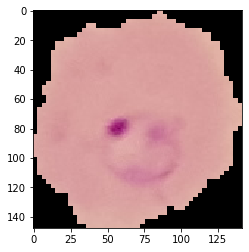

In [13]:
plt.imshow(para_img)

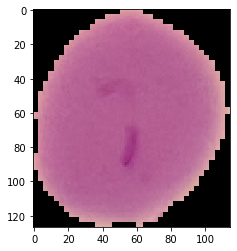

In [14]:
# Check out the image for an uninfected cell
uninfected_cell_path = train_path+'/uninfected/'+ \
                        os.listdir(train_path+'/uninfected')[0]
uninfected_img = imread(uninfected_cell_path)
plt.imshow(uninfected_img)

In [15]:
uninfected_img.shape

(127, 115, 3)

**Let's check how many images there are.**

In [16]:
len(os.listdir(train_path+'/parasitized'))

12480

In [17]:
len(os.listdir(train_path+'/uninfected'))

12480

In [18]:
len(os.listdir(test_path+'/parasitized'))

1300

In [19]:
len(os.listdir(test_path+'/uninfected'))

1300

**Images are of different sizes. Let's find out the average dimensions of these images.**

In [20]:
uninfected_img.shape

(127, 115, 3)

In [21]:
para_img.shape

(148, 142, 3)

In [22]:
dim1 = []
dim2 = []

for image_filename in os.listdir(test_path+'/uninfected'):    
    img = imread(test_path+'/uninfected/'+image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

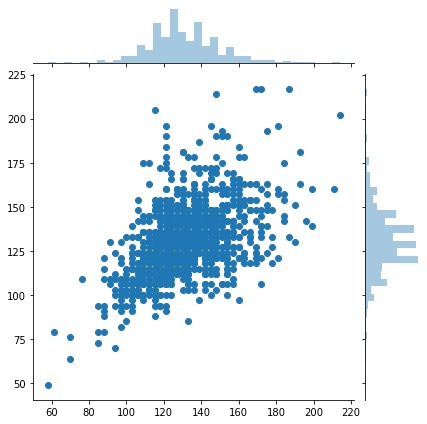

In [23]:
sns.jointplot(dim1, dim2)

In [24]:
np.mean(dim1)

130.92538461538462

In [25]:
np.mean(dim2)

130.75

In [26]:
image_shape = (130,130,3)   # fix the average image shape for training

## Preparing the Data for the model

There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Data Augmentation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us.

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image +/- 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 10%
                               height_shift_range=0.10, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               # shear_range=10, # Shear means cutting away part of image in degree
                               zoom_range=0.1, # Zoom in or out by 10% max
                               horizontal_flip=True, # Allow horizontal flipping
                               cval=0, # fill pixel value
                               fill_mode='constant' # Fill in missing pixels with the specified fill value
                              )

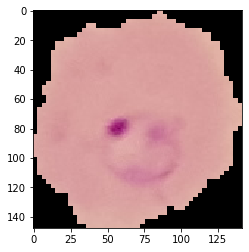

In [29]:
plt.imshow(para_img)

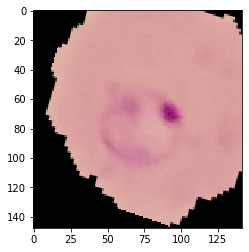

In [32]:
# to preview a transformed (augmented) image
plt.imshow(image_gen.random_transform(para_img))

### Generating many manipulated images from a directory


In order to use .flow_from_directory, you must organize the images in sub-directories. This is an absolute requirement, otherwise the method won't work. The directories should only contain images of one class, so one folder per class of images.

Structure Needed:

* Image Data Folder
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n

In [38]:
batch_size = 16

In [39]:
# create an iterator for an image dataset located in a specified directory
# the iterator will return 1 batch of augmented images for each iteration

train_image_gen = image_gen.flow_from_directory(train_path,
                                            target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [40]:
# create a separate test generator without data augmentation

test_gen = ImageDataGenerator(rescale=1/255)

In [41]:
test_image_gen = test_gen.flow_from_directory(test_path,
                                            target_size=image_shape[:2],
                                            color_mode='rgb',
                                            batch_size=batch_size,
                                            class_mode='binary', 
                                            shuffle=False)

Found 2600 images belonging to 2 classes.


In [42]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [43]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

# Creating the Model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Conv2D, MaxPool2D, Dropout,
                                     Flatten)

In [34]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=5, strides=2,
                 activation='relu', input_shape=image_shape))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 63, 63, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0

## Early Stopping

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,
                          restore_best_weights=True)

## Training the Model

In [44]:
# fit model with an iterator train set

model.fit(train_image_gen, epochs=20,
          validation_data=test_image_gen,
          callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 140s 90ms/step - loss: 0.3598 - accuracy: 0.8241 - val_loss: 0.1662 - val_accuracy: 0.9508
Epoch 2/20
1560/1560 [==============================] - 141s 90ms/step - loss: 0.1884 - accuracy: 0.9424 - val_loss: 0.1749 - val_accuracy: 0.9477
Epoch 3/20
1560/1560 [==============================] - 137s 88ms/step - loss: 0.1762 - accuracy: 0.9473 - val_loss: 0.1491 - val_accuracy: 0.9527
Epoch 4/20
1560/1560 [==============================] - 139s 89ms/step - loss: 0.1740 - accuracy: 0.9470 - val_loss: 0.1476 - val_accuracy: 0.9512
Epoch 5/20
1560/1560 [==============================] - 140s 90ms/step - loss: 0.1691 - accuracy: 0.9468 - val_loss: 0.1578 - val_accuracy: 0.9469
Epoch 6/20
1560/1560 [==============================] - 141s 91ms/step - loss: 0.1670 - accuracy: 0.9483 - val_loss: 0.1438 - val_accuracy: 0.9546
Epoch 7/20
1560/1560 [==============================] - 135s 87ms/step - loss: 0.1609 - accuracy: 0.9492 - val_loss: 0

In [72]:
# can optionally save the trained model
# model.save('malaria_detector.h5')

In [74]:
# from tensorflow.keras.models import load_model
# model = load_model('malaria_detector.h5')

## Evaluating the Model

In [45]:
losses = pd.DataFrame(model.history.history)

In [46]:
losses

,loss,accuracy,val_loss,val_accuracy
0,0.359772,0.824145,0.166170,0.950769
1,0.188372,0.942383,0.174862,0.947692
2,0.176227,0.947311,0.149141,0.952692
3,0.174028,0.946991,0.147565,0.951154
4,0.169106,0.946791,0.157806,0.946923
5,0.167002,0.948313,0.143829,0.954615
6,0.160880,0.949235,0.152636,0.947308
7,0.161255,0.949715,0.151398,0.950769
8,0.162509,0.948794,0.138736,0.955385
9,0.159982,0.949756,0.130485,0.953846


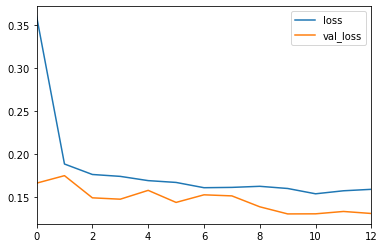

In [47]:
losses[['loss','val_loss']].plot()

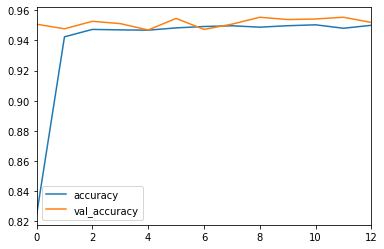

In [48]:
losses[['accuracy', 'val_accuracy']].plot()

In [49]:
model.metrics_names

['loss', 'accuracy']

In [59]:
model.evaluate(test_image_gen, verbose=0)

[0.1304846554994583, 0.9538461565971375]

In [52]:
pred_probabilities = model.predict(test_image_gen)
pred_probabilities[:10]

array([[6.0350597e-03],
       [2.7343631e-04],
       [4.1228533e-04],
       [5.1360130e-03],
       [2.1053511e-01],
       [5.4544210e-04],
       [1.5718341e-03],
       [7.2270632e-04],
       [1.3714625e-06],
       [3.7986822e-05]], dtype=float32)

In [53]:
predictions = (pred_probabilities > 0.5) * 1
predictions[:10]       # convert the probabilities to predicted label

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [54]:
test_image_gen.classes   # this is the actual image label

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [55]:
from sklearn.metrics import classification_report, confusion_matrix

In [56]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1300
           1       0.95      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [57]:
confusion_matrix(test_image_gen.classes, predictions)

array([[1233,   67],
       [  53, 1247]])

# Predicting on an Image

In [60]:
from tensorflow.keras.preprocessing import image

In [61]:
# Pick a sample parasitized image from the test_path
sample = test_path + 'parasitized/' + os.listdir(test_path + \
                                                 'parasitized/')[0]

In [62]:
my_image = image.load_img(sample, target_size=image_shape)
type(my_image)

PIL.Image.Image

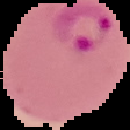

In [63]:
my_image

In [64]:
my_image = image.img_to_array(my_image)
type(my_image)

numpy.ndarray

In [65]:
my_image.shape

(130, 130, 3)

In [67]:
my_image = np.expand_dims(my_image, axis=0)  # reshape to add batch dimension
my_image.shape

(1, 130, 130, 3)

In [66]:
my_image.max()

224.0

In [68]:
my_image = my_image / 255  # normalize the pixel values
my_image.max()

0.8784314

In [69]:
model.predict(my_image)    # predict probability

array([[5.0857972e-05]], dtype=float32)

In [70]:
(model.predict(my_image) > 0.5).astype(int)  # convert to predicted label

array([[0]])

In [71]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [ ]:
# our model predicted correctly for this parasitized image